# Figs. 4F, 4J; Ext. Data Figs. 6B, 6C
## Population-level event rate changes

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
# Typing

from typing import (
    Optional,
    Union,
    Any,
)
from matplotlib.pyplot import (
    Axes,
)
from numpy.typing import(
    ArrayLike,
)
from pandas import (
    DataFrame,
)

# Others

from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.stats.multitest as multitest
import matplotlib.pyplot as plt

from tqdm import tqdm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents
import uncaging.stats as ustats

#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-4f_4j_s6b_s6c.yaml'
params = uutils.load_params( params_path )

These could be put in the params `.yaml` file if you'd like, but they're the most likely to be modulated so for simplicity let's have them here:

In [3]:
# Choices for `analysis`:
# * 'wt' - wild-type dataset (Fig. 4F, S6B)
# * 'cx43' - connexin-43 conditional knock out dataset (Fig. 4J, S6C)
params['analysis'] = 'wt'

#### Initial setup

In [4]:
helper = Helper(
    config_path = params['helper_configs'],
    hive_root = params['hive_root'],
    output_to = params['output_parent']
)

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [5]:
events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = [],
    verbose = True
)

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 18.97it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 42.56it/s]
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:01<00:00, 32.25it/s] 



Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99


Experiment GABA
    Excluded cells: 154
    Included cells: 164



In [6]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

### Common

#### Statistic functions

TODO: These encapsulate functions that generalize to enable point-aggregating estimates; needed?

def stat_rate(
        df: DataFrame,
        window: uevents.Window,
        point_key: Optional[str] = None
    ) -> float:
    """
    TODO
    """
    
    if point_key is None:
        rate_window = uevents.rate_within( df['start_time_rel'], window )
        return rate_window
    
    point_rates = uevents.group_rates( df, point_key,
                                       windows = [window] )
    # `nan`s shouldn't arise here, but using for consistency
    return np.nanmean( point_rates['rate_1'] )

def stat_rate_rel(
        df: DataFrame,
        window_baseline: uevents.Window,
        window: uevents.Window,
        point_key: Optional[str] = None
    ) -> float:
    """
    TODO
    """
    
    if point_key is None:
        rate_baseline = uevents.rate_within( df['start_time_rel'], window_baseline )
        rate_window = uevents.rate_within( df['start_time_rel'], window )
        return rate_window / rate_baseline
    
    windows = [window_baseline, window]
    point_rates = uevents.group_rates( df, point_key,
                                       windows = windows )
    point_rates['rel'] = point_rates['rate_2'] / point_rates['rate_1']
        
    # This excludes all points that have no events in the baseline period
    return np.nanmean( point_rates )

##### Main analysis

RateResult = 'dict[dict[str, Any]]'

def population_rate_windowed(
        df: DataFrame,
        group_key: str,
        groups: str,
        window_baseline: uevents.Window = (-60, 0),
        windows_compare: Optional['list[uevents.Window]'] = None,
        point_key: Optional[str] = None,
        keep_keys: 'list[str]' = [],
        n_boot: int = 200,
        n_perm: int = 200,
        window_perm: uevents.Window = (-90, 150),
        hierarchy_boot: 'list[str]' = ['fov', 'cell'],
        verbose: bool = False
    ) -> Union[RateResult, 'tuple[RateResult, DataFrame]']:
    """
    TODO
    """
    
    if windows_compare is None:
        windows_compare = [window_baseline] + uutils.bucket_list( (0, 150), 5 )
    
    ret = { group: []
            for group in groups }
    
    if verbose:
        it = tqdm( windows_compare )
    else:
        it = windows_compare
    
    for window in it:
        
        # Statistics (dataset -> float)

        stat = lambda df: stat_rate( df, window,
                                     point_key = point_key )
        stat_rel = lambda df: stat_rate_rel( df, window_baseline, window,
                                             point_key = point_key )
        
        for i_group, group in enumerate( groups ):
            
            filter_events_group = df[group_key] == group
            events_group = df[filter_events_group]
            
            # Actual statistic values

            rate = stat( events_group )
            rate_rel = stat_rel( events_group )
            
            # Bootstrap distributions (resampling using empirical CDF)

            rate_boot = ustats.bootstrap_stat_hierarchical(
                stat,
                events_group,
                hierarchy_boot,
                n = n_boot
            )
            rate_rel_boot = ustats.bootstrap_stat_hierarchical(
                stat_rel,
                events_group,
                hierarchy_boot,
                n = n_boot
            )
            
            # Permuted distributions (resampling using imposed null)

            rate_perm = ustats.perm_stat_ts(
                stat,
                events_group,
                window_perm,
                n = n_perm
            )
            rate_rel_perm = ustats.perm_stat_ts(
                stat_rel,
                events_group,
                window_perm,
                n = n_perm
            )
            
            # Cache results

            cur_entry = dict()
            cur_entry['window'] = window
            
            cur_entry['rate'] = rate
            cur_entry['rate_boot'] = rate_boot
            cur_entry['rate_perm'] = rate_perm
            
            cur_entry['rate_rel'] = rate_rel
            cur_entry['rate_rel_boot'] = rate_rel_boot
            cur_entry['rate_rel_perm'] = rate_rel_perm
            
            ret[group].append( cur_entry )
    
    if point_key is None:
        return ret

    ## Make data formatted for individual-datapoint plot display
    ## (aggregated over groupings of `point_key`)
    
    ret_table_data = dict()

    ret_table_data[point_key] = []
    for k in keep_keys:
        ret_table_data[k] = []
    ret_table_data[group_key] = []
    ret_table_data['window_compare'] = []
    ret_table_data['window_start'] = []
    ret_table_data['window_end'] = []
    ret_table_data['rate'] = []

    it_group = df.groupby( point_key )
    if verbose:
        it = tqdm( it_group )
    else:
        it = it_group
    
    for point, events_point in it:
        
        keep_key_vals = { k: events_point.iloc[0][k]
                            for k in keep_keys }
            
        for group in groups:
            filter_point_group = events_point[group_key] == group
            events_point_group = events_point[filter_point_group]
            
            for i_window, window in enumerate( windows_compare ):
                
                # Statistic (dataset -> float) for current window
                cur_stat = lambda ts: uevents.rate_within( ts, window )
                
                # Actual stat value
                cur_val = cur_stat( events_point_group['start_time_rel'] )

                # Cache results
                ret_table_data[point_key].append( point )
                for k in keep_keys:
                    ret_table_data[k].append( keep_key_vals[k] )
                ret_table_data[group_key].append( group )
                ret_table_data['window_compare'].append( i_window )
                ret_table_data['window_start'].append( window[0] )
                ret_table_data['window_end'].append( window[1] )
                ret_table_data['rate'].append( cur_val )
    
    ret_table = pd.DataFrame( ret_table_data )
    return ret, ret_table

def population_rate_p_table(
        result: RateResult,
        two_sided: bool = False
    ) -> DataFrame:
    """
    TODO
    """
    
    ret = pd.DataFrame()

    for group, group_result in result.items():
        for window_result in group_result:
            rate_rel = window_result['rate_rel']
            rate_rel_perm = window_result['rate_rel_perm']
            n_perm = len( rate_rel_perm )

            cur_row = dict()
            cur_row['group'] = group
            cur_row['window_start'] = window_result['window'][0]
            cur_row['window_end'] = window_result['window'][1]

            if two_sided:
                n_deviated = np.sum(
                    (rate_rel_perm >= rate_rel)
                    | (rate_rel_perm <= (1./rate_rel))
                )
            else:
                n_deviated = np.sum( (rate_rel_perm >= rate_rel) )
            p_perm = ustats.perm_p( n_deviated, n_perm )
            cur_row['p_perm'] = p_perm

            # `append`!!
            # ret = ret.append( cur_row, ignore_index = True )
            cur_row_df = pd.DataFrame( cur_row, index = [0] )
            ret = pd.concat( [ret, cur_row_df], ignore_index = True )
    
    filter_correction = ret['window_start'] >= 0.
    ret_correction = ret[filter_correction]
    p_correction = ret_correction['p_perm']

    rejected, q_correction = multitest.fdrcorrection( p_correction,
                                                      method = 'p',
                                                      alpha = 0.05 )

    new_column = np.ones( (ret.shape[0],) )
    new_column[filter_correction] = q_correction

    ret['q_corrected'] = new_column
    
    return ret

In [7]:
def stat_rate_rel( events, window_baseline, window,
                   point_key = None ):
    
    if point_key is None:
        rate_baseline = uevents.rate_within( events['start_time_rel'], window_baseline )
        rate_window = uevents.rate_within( events['start_time_rel'], window )
        return rate_window / rate_baseline
    
    points = events[point_key].unique()
    
    # Do this pointwise
    point_rates = []
    for point in points:
        filter_point = events[point_key] == point
        events_point = events[filter_point]
        
        rate_baseline = uevents.rate_within( events_point['start_time_rel'], window_baseline )
        rate_window = uevents.rate_within( events_point['start_time_rel'], window )
        
        point_rate = rate_window / rate_baseline if rate_baseline > 0. else np.nan
        point_rates.append( point_rate )
        
    # This excludes all points that have no events in the baseline or comparison period
    return np.nanmedian( point_rates )
    # return np.nanmean( point_rates )

def population_rate_windowed( events, group_key, groups,
                              window_baseline = (-60, 0),
                              windows_compare = None,
                              point_key = None,
                              n_boot = 200,
                              n_perm = 200,
                              window_perm = (-90, 150),
                              hierarchy_boot = ['fov', 'cell'],
                              verbose = False ):
    
    if windows_compare is None:
        windows_compare = [window_baseline] + uutils.bucket_list( (0, 150), 5 )
    
    ret = { group: []
            for group in groups }
    
    if verbose:
        it = tqdm( windows_compare )
    else:
        it = windows_compare
    
    for window in it:
        
        stat = lambda df: stat_rate_rel( df, window_baseline, window,
                                         point_key = point_key )
        
        for i_group, group in enumerate( groups ):
            
            filter_events_group = events[group_key] == group
            events_group = events[filter_events_group]
            
            rate_rel = stat( events_group )
            
            # Compute bootstrap distribution (resampling)
            rate_rel_boot = ustats.bootstrap_stat_hierarchical( stat, events_group, hierarchy_boot,
                                                                  n = n_boot )
            
            # Compute permuted distribution (sampled under imposed null)
            rate_rel_perm = ustats.perm_stat_ts( stat, events_group, window_perm,
                                                 n = n_perm )
            
            cur_entry = dict()
            cur_entry['window'] = window
            cur_entry['rate_rel'] = rate_rel
            cur_entry['rate_rel_boot'] = rate_rel_boot
            cur_entry['rate_rel_perm'] = rate_rel_perm
            ret[group].append( cur_entry )
    
    return ret

def population_rate_p_table( result,
                             two_sided = False ):
    
    ret = pd.DataFrame()

    for group, group_result in result.items():
        for window_result in group_result:
            rate_rel = window_result['rate_rel']
            rate_rel_perm = window_result['rate_rel_perm']

            cur_row = dict()
            cur_row['group'] = group
            cur_row['window_start'] = window_result['window'][0]
            cur_row['window_end'] = window_result['window'][1]

            if two_sided:
                n_deviated = np.sum( (rate_rel_perm >= rate_rel) | (rate_rel_perm <= (1./rate_rel)) )
            else:
                n_deviated = np.sum( (rate_rel_perm >= rate_rel) )
            p_perm = ustats.perm_p( n_deviated, rate_rel_perm.shape[0] )
            cur_row['p_perm'] = p_perm

            # ret = ret.append( cur_row, ignore_index = True )
            ret_cur = pd.DataFrame( cur_row, index = [0] )
            ret = pd.concat( [ret, ret_cur], ignore_index = True )

    filter_correction = ret['window_start'] >= 0.
    ret_correction = ret[filter_correction]
    p_correction = ret_correction['p_perm']

    rejected, q_correction = multitest.fdrcorrection( p_correction,
                                                      method = 'p',
                                                      alpha = 0.05 )

    new_column = np.ones( (ret.shape[0],) )
    new_column[filter_correction] = q_correction

    ret['q_corrected'] = new_column
    
    return ret

##### Plotting

def population_rate_plot_windowed(
        ax: Axes,
        result: RateResult,
        spec: 'dict[str, Any]',
        p_table: DataFrame = None,
        sig_key: str = 'q_corrected',
        normalized: bool = True,
        markersize: float = 10,
        linewidth_ci: float = 1,
        linewidth_unity: float = 1,
        linewidth_xticks: float = 1,
        ylim: Optional[ArrayLike] = None,
        xticks: Optional[ArrayLike] = None,
        quantile: Optional[float] = 0.05
    ):
    """
    TODO
    """
    
    eps = 0.0001
    
    for index, (group, color) in enumerate( spec.items() ):
        
        for entry in result[group]:
        
            window = entry['window']
            dx = (window[1] - window[0]) / (len( spec.keys() ) + 1)
            x_plot = window[0] + (index + 1) * dx
            
            if normalized:
                vals = entry['rate_rel']
                vals_boot = entry['rate_rel_boot']
            else:
                vals = 60. * entry['rate']
                vals_boot = 60. * entry['rate_boot']
            
            mean = vals
            
            if quantile is None:
                std = np.std( vals_boot )
                low = mean - std
                high = mean + std
            else:
                low = np.quantile( vals_boot, quantile / 2. )
                high = np.quantile( vals_boot, 1. - (quantile / 2.) )
        
            ax.plot( x_plot, mean, f'{color}.',
                     markersize = markersize )
            ax.plot( [x_plot, x_plot], [low, high], f'{color}-',
                     linewidth = linewidth_ci )
            
            if p_table is not None:
                filter_group = p_table['group'] == group
                filter_window = (
                    (np.abs( p_table['window_start'] - window[0] ) < eps)
                    & (np.abs( p_table['window_end'] - window[1] ) < eps)
                )
                p_row = p_table[filter_group & filter_window].iloc[0]
                
                ax.text( x_plot, high + 0.2, uutils.p_text( p_row[sig_key] ),
                         color = color,
                         horizontalalignment = 'center',
                         verticalalignment = 'center' )
    
    # TODO Infer this from the data
    if xticks is not None:
        ax.set_xticks( xticks )
    
    xlim = ax.get_xlim()
    
    if normalized:
        ax.plot( xlim, [1, 1], 'k-',
                 linewidth = linewidth_unity )
        ax.set_xlim( xlim )
    
    if ylim is not None:
        ax.set_ylim( ylim )
    else:
        ylim = ax.get_ylim()
        
    if xticks is not None:
        for x in xticks:
            ax.plot( [x, x], ylim, 'k--',
                     linewidth = linewidth_xticks )
    
    ax.set_xlabel( 'Time after uncaging (s)' )
    
    if normalized:
        ax.set_ylabel( 'Event rate (multiple of baseline)' )
    else:
        ax.set_ylabel( 'Event rate (min$^{-1}$)' )

In [8]:
def population_rate_plot_windowed( ax, result, spec,
                                   p_table = None,
                                   sig_key = 'q_corrected',
                                   markersize = 10,
                                   linewidth_ci = 1,
                                   linewidth_unity = 1,
                                   linewidth_xticks = 1,
                                   ylim = None,
                                   xticks = None,
                                   quantile = 0.05 ):
    
    eps = 0.0001
    
    for index, (group, color) in enumerate( spec.items() ):
        
        for entry in result[group]:
        
            window = entry['window']
            dx = (window[1] - window[0]) / (len( spec ) + 1)
            x_plot = window[0] + (index + 1) * dx
            
            mean = entry['rate_rel']
            
            if quantile is None:
                std = np.std( entry['rate_rel_boot'] )
                low = mean - std
                high = mean + std
            else:
                low = np.quantile( entry['rate_rel_boot'], quantile / 2. )
                high = np.quantile( entry['rate_rel_boot'], 1. - (quantile / 2.) )
        
            ax.plot( x_plot, mean, f'{color}.', markersize = markersize )
            ax.plot( [x_plot, x_plot], [low, high], f'{color}-', linewidth = linewidth_ci )
            
            if p_table is not None:
                filter_group = p_table['group'] == group
                filter_window = (np.abs( p_table['window_start'] - window[0] ) < eps) & (np.abs( p_table['window_end'] - window[1] ) < eps)
                p_row = p_table[filter_group & filter_window].iloc[0]
                
                ax.text( x_plot, high + 0.2, uutils.p_text( p_row[sig_key] ),
                         color = color,
                         horizontalalignment = 'center',
                         verticalalignment = 'center' )
    
    # TODO Infer this from the data
    if xticks is not None:
        ax.set_xticks( xticks )
    
    xlim = ax.get_xlim()
    ax.plot( xlim, [1, 1], 'k-', linewidth = linewidth_unity )
    ax.set_xlim( xlim )
    
    if ylim is not None:
        ax.set_ylim( ylim )
    else:
        ylim = ax.get_ylim()
        
    if xticks is not None:
        for x in xticks:
            ax.plot( [x, x], ylim, 'k--', linewidth = linewidth_xticks )
    
    ax.set_xlabel( 'Time after uncaging (s)' )
    ax.set_ylabel( 'Event rate (multiple of baseline)' )

### Static event rates
* `wt`: S6B
* `cx43`: S6C

In [9]:
comparison_key = params['comparison_key']
comparison_groups = params['comparison']

events_subset = events_no_prop.copy()

filter_events_condition = events_subset[comparison_key].isin( comparison_groups )
filter_events_neighbor = events_subset['is_uncage'] == False
filter_events_panel = filter_events_condition & filter_events_neighbor

events_panel = events_subset.copy()[filter_events_panel]

In [10]:
uevents.summarize_n( events_panel )

Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 262
Cells:           n = 174
Events:          n = 15415
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  10
    High: 214

** GABA:
Datasets:        n = 28
Cell-recordings: n = 142
Events:          n = 8417
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 120
Events:          n = 6998
Cells per dataset:
    Low:  1
    High: 7


#### Run

In [11]:
# result, result_table = population_rate_windowed(
result = population_rate_windowed(
    events_panel,
    params['comparison_key'],
    params['comparison'],
    verbose = True,
    **params['rate_stats']
)

100%|██████████| 6/6 [2:47:15<00:00, 1672.55s/it]


In [12]:
result_p_table = population_rate_p_table( result,
                                          two_sided = False )

#### Plot

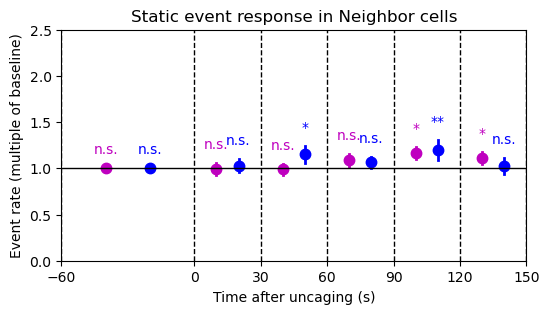

In [13]:
plot_spec = { k: helper.condition_colors[k]
              for k in params['comparison'] }

fig, ax = plt.subplots( figsize = (6, 3) )

params['rate_plot']['ylim'] = [0, 100]

population_rate_plot_windowed( ax, result, plot_spec,
                               p_table = result_p_table,
                               **params['rate_plot'] )

ax.set_title( 'Static event response in Neighbor cells' )

plt.ylim(0, 2.5)

save_figure( 'rate-population-window-nonprop' )

plt.show()

### Propagative event rates
* `wt`: 4f
* `cx43`: 4j

In [14]:
events_subset = events_prop.copy()

filter_events_condition = events_subset[comparison_key].isin( comparison_groups )
filter_events_neighbor = events_subset['is_uncage'] == False
filter_events_panel = filter_events_condition & filter_events_neighbor

events_panel = events_subset.copy()[filter_events_panel]

In [15]:
uevents.summarize_n( events_panel )

Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 250
Cells:           n = 167
Events:          n = 2470
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  1
    High: 52

** GABA:
Datasets:        n = 28
Cell-recordings: n = 135
Events:          n = 1358
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 115
Events:          n = 1112
Cells per dataset:
    Low:  1
    High: 7


In [16]:
# result, result_table = population_rate_windowed(
result = population_rate_windowed(
    events_panel,
    params['comparison_key'],
    params['comparison'],
    verbose = True,
    **params['rate_stats']
)

100%|██████████| 6/6 [24:36<00:00, 246.04s/it]


In [17]:
result_p_table = population_rate_p_table( result,
                                          two_sided = False )

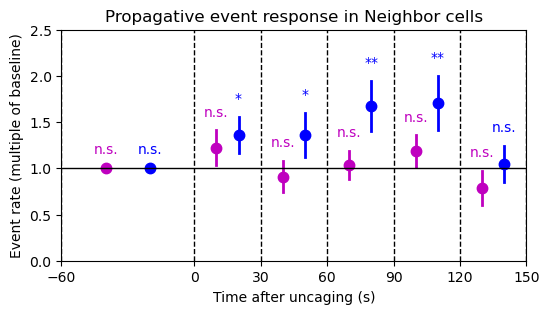

In [18]:
plot_spec = { k: helper.condition_colors[k]
              for k in params['comparison'] }

fig, ax = plt.subplots( figsize = (6, 3) )

params['rate_plot']['ylim'] = [0, 100]

population_rate_plot_windowed( ax, result, plot_spec,
                               p_table = result_p_table,
                               **params['rate_plot'] )

ax.set_title( 'Propagative event response in Neighbor cells' )

plt.ylim(0, 2.5)

save_figure( 'rate-population-window-nprop' )

plt.show()